In [1]:
from sklearn.metrics import confusion_matrix, classification_report 
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    myMatrix = confusion_matrix(labels, predicted,normalize = 'all')     
    return  errorScore/len(predicted), myMatrix

In [2]:
from tabulate import tabulate
def catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels):
    catIndicies = []
    counter = -1
    for col in sectorDF.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.append(counter)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList = \
    train_test_split(masterList, zScoreAnswer, fiveDayChangeAnswer,test_size = .3)

    trainPools = [Pool(data = masterTrainList, label = zScoreTrainList, cat_features = catIndicies),
                  Pool(data = masterTrainList, label = fiveDayChangeTrainList, cat_features = catIndicies)]
    testPools = [Pool(data = masterTestList, label = zScoreTestList, cat_features = catIndicies),
                Pool(data = masterTestList, label = fiveDayChangeTestList, cat_features = catIndicies)]
    modelNames = ['ZScorePredictor','FiveDayPredictor','MarketBeaterPredictor']
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    print('Catboost:')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in sectorDF.columns])
        print(name)
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli')
        model.fit(train, eval_set = test, logging_level = 'Silent')
        sector = sector.replace(' ', '_')
        model.save_model(folderRoot + name + sector + '.cbm')
        accuracy =  model.score(test)
        print('Accuracy: ', accuracy)
        print(CatBoostClassifier.get_feature_importance(model, prettified = True))
        error, matrix = scoreCalculator(model, test,test.get_label())
        print('Error Score:', error)
        print('Confusion matrix:\n', matrix, '\n')
        accuracyList.append(accuracy)
        scoreList.append(error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    return averageAccuracy, averageScore

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import json
import os
from tabulate import tabulate

def sciKitPredictionMaker(sectorDF,zScoreAnswer, fiveDayChangeAnswer, sector, catLabels):

    folderRoot = 'sciKitPredictors/'
    print('\nSci-Kit:')
    sectorDF.drop(columns = catLabels, inplace = True)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList, zScoreAnswer, fiveDayChangeAnswer, test_size = .3)
    
    
    hyperParamDict = {'accuracy': 0,
    'error_score': -np.inf,
    'min_samples_split': 5,
    'min_impurity_decrease': 0}
    min_samples_splitChoices = [5,15,20]
    min_impurity_decreaseChoices = [0, 0.000005, 0.00001, 0.00005]
    trainTestBundles = [['zScore', zScoreTrainList, zScoreTestList, hyperParamDict.copy()],
                        ['fiveDay',fiveDayChangeTrainList, fiveDayChangeTestList, hyperParamDict.copy()]]

    for bundle in trainTestBundles:
        for minSplit in min_samples_splitChoices:
            for minImpurity in min_impurity_decreaseChoices:
                errorScoreList = []
                accuracyList = []
                for randState in range(3):
                    predictor = RandomForestClassifier(min_samples_split = minSplit, min_impurity_decrease = minImpurity,
                        random_state = randState, n_jobs = 2)
                    predictor.fit(masterTrainList, bundle[1])
                    predictions = predictor.predict(masterTestList)
                    predictionAccuracy = accuracy_score(bundle[2],predictions)
                    feature = pd.DataFrame(predictor.feature_importances_,
                                                        index = sectorDF.columns,
                                                        columns=['importance']).sort_values('importance', ascending=False)
                    errorScore, _ = scoreCalculator(predictor, masterTestList, zScoreTestList)
                    errorScoreList.append(errorScore)
                    accuracyList.append(predictionAccuracy)
                errorScore = sum(errorScoreList)/len(errorScoreList)
                predictionAccuracy = sum(accuracyList)/len(accuracyList)
                if errorScore > bundle[3]['error_score']:
                    bundle[3]['accuracy'] = predictionAccuracy
                    bundle[3]['error_score'] = errorScore
                    bundle[3]['min_samples_split'] = minSplit
                    bundle[3]['min_impurity_decrease'] = minImpurity
    print('Final result:')
    for x in trainTestBundles:
        print(x[0], ' ', x[3])
    for bundle in trainTestBundles:
        print('bundle')
        predictor = RandomForestClassifier(min_samples_split = bundle[3]['min_samples_split'], 
        min_impurity_decrease = bundle[3]['min_impurity_decrease'], random_state = 1, n_jobs = 2)
        predictor.fit(masterTrainList, bundle[1])
        
        headers = ["name", "score"]
        values = sorted(zip(sectorDF.columns, predictor.feature_importances_), key=lambda x: x[1] * -1)
        print(tabulate(values, headers, tablefmt="plain"))
        
        _, matrix = scoreCalculator(predictor, masterTestList, zScoreTestList)
        print(bundle[0], ' confusion matrix\n',matrix)
        sector = sector.replace(' ', '_')
        pickle.dump(predictor, open(folderRoot + bundle[0] + sector + '.pkl', 'wb'))
    averageAccuracy = sum([trainTestBundles[x][3]['accuracy'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    averageScore = sum([trainTestBundles[x][3]['error_score'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    return averageAccuracy, averageScore

VolumeZScoreTenDay
highVsLowPerc
dayPercentChange
ticker
fiveVSTenDayWeightedAverage
fiveVsTenDaySlopeChange
fiveVsTenDayAverage
MACD
bPercent
rsi
slowVSFastKAMA
aroon
bop
MFI
WilliamsR
zScoreOfChangeTmmrw
percentChangeInFiveDays
typPrice
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
vsMarketPerformance
titleSent
articleSent
titleSentChangeSinceYesterday
articleSentChangeSinceYesterday
titleSentbPercent
articleSentbPercent
DTWEXAFEGSValue
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEfiveVsTenTickAverage
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATElastChangeP
UNRATEfiveVsTenTickAverage
UNRATEbPercent
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSlastChangeP
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
CCLACBW027SBOGfiveVsTenTickAverage
CCLACBW027SBOG

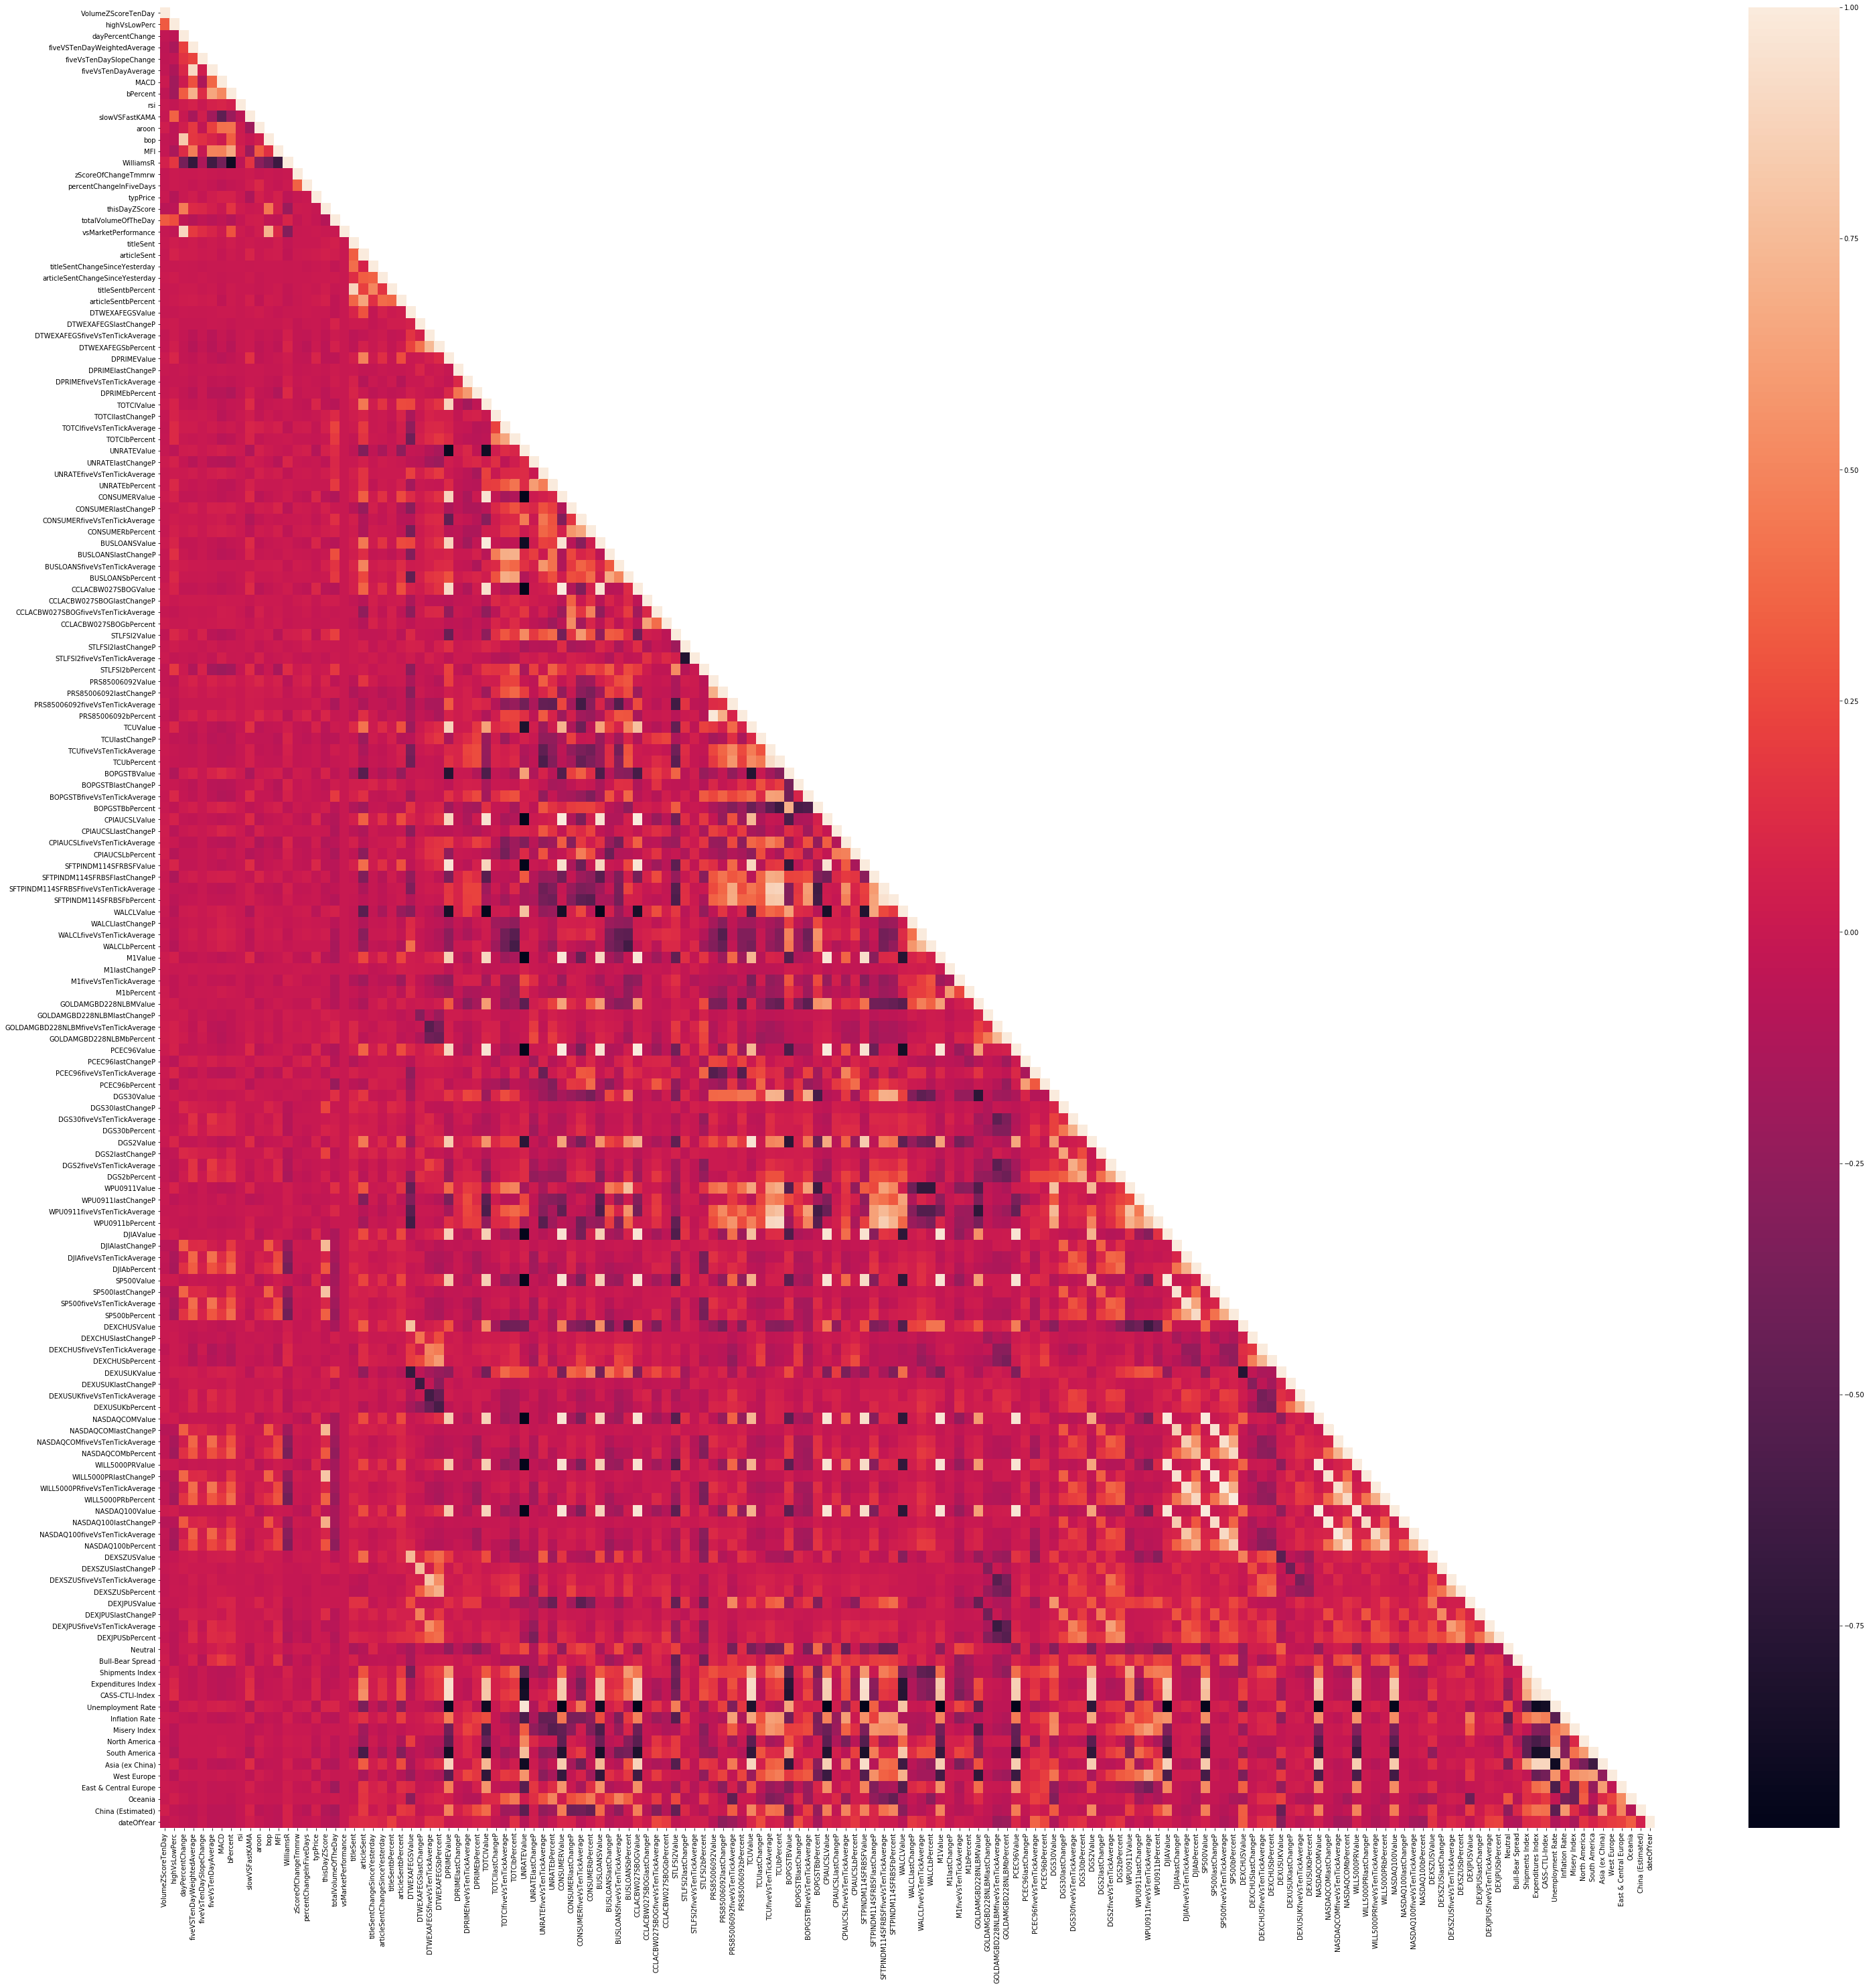

-------------------------------------------


Sector is:  Health Care
Catboost:
ZScorePredictor
Accuracy:  0.610461914958703
                                Feature Id  Importances
0                           slowVSFastKAMA     2.633526
1                            highVsLowPerc     2.319242
2                                 typPrice     1.962079
3                       VolumeZScoreTenDay     1.943621
4                       DEXCHUSlastChangeP     1.867984
5                       DEXSZUSlastChangeP     1.797413
6                      totalVolumeOfTheDay     1.768071
7                        GICS Sub Industry     1.697332
8                        titleSentbPercent     1.696535
9            titleSentChangeSinceYesterday     1.582053
10             GOLDAMGBD228NLBMlastChangeP     1.544887
11                         DJIAlastChangeP     1.462605
12                            DGS2bPercent     1.457230
13                 fiveVsTenDaySlopeChange     1.423236
14                      DEXJPUSlast

Error Score: 3.0816763536249616
Confusion matrix:
 [[0.42679719 0.04631386 0.04307128]
 [0.14842459 0.08883451 0.01107372]
 [0.13141634 0.0092383  0.09483022]] 

FiveDayPredictor
Accuracy:  0.6427653716732946
                                Feature Id  Importances
0                                    aroon     6.071640
1                           slowVSFastKAMA     4.069743
2                        GICS Sub Industry     3.460726
3                                 typPrice     3.042122
4                                   ticker     2.768400
5                                     MACD     2.364239
6                                      rsi     1.970733
7                                 bPercent     1.958634
8                      fiveVsTenDayAverage     1.725410
9                                      MFI     1.713659
10             fiveVSTenDayWeightedAverage     1.698170
11                 fiveVsTenDaySlopeChange     1.696854
12                        TOTCIlastChangeP     1.618976
13     

Error Score: 6.276537167329459
Confusion matrix:
 [[0.27243805 0.08308351 0.048394  ]
 [0.09623738 0.22624656 0.01774243]
 [0.08779443 0.02398287 0.14408076]] 


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6069950035688794, 'error_score': 3.464566126236362, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6057102069950036, 'error_score': 1.4774140919751197, 'min_samples_split': 20, 'min_impurity_decrease': 5e-05}
bundle
name                                         score
highVsLowPerc                          0.0427395
slowVSFastKAMA                         0.041076
typPrice                               0.0395614
VolumeZScoreTenDay                     0.0395236
fiveVsTenDaySlopeChange                0.0395017
MACD                                   0.0381996
fiveVsTenDayAverage                    0.0380365
fiveVSTenDayWeightedAverage            0.0378366
vsMarketPerformance                    0.0377016
bPercent                               0.0375256
Willi

zScore  confusion matrix
 [[0.39932701 0.05830529 0.05371673]
 [0.13251759 0.1022331  0.01095136]
 [0.1267666  0.0111349  0.10504742]]
bundle
name                                         score
slowVSFastKAMA                         0.0372168
aroon                                  0.0333127
highVsLowPerc                          0.0300563
typPrice                               0.0266184
MACD                                   0.0236411
fiveVSTenDayWeightedAverage            0.0233449
fiveVsTenDayAverage                    0.0221195
rsi                                    0.0214638
bPercent                               0.0214145
fiveVsTenDaySlopeChange                0.0206633
MFI                                    0.020208
WilliamsR                              0.0193235
VolumeZScoreTenDay                     0.0179524
vsMarketPerformance                    0.0175838
dayPercentChange                       0.0173684
bop                                    0.0171255
dateOfYear              

Accuracy:  0.6305084745762712
                                Feature Id  Importances
0                            highVsLowPerc     2.406375
1                                 typPrice     2.234233
2                           slowVSFastKAMA     2.190109
3                       VolumeZScoreTenDay     1.986483
4                       DEXCHUSlastChangeP     1.935379
5          articleSentChangeSinceYesterday     1.818663
6              GOLDAMGBD228NLBMlastChangeP     1.787378
7                      totalVolumeOfTheDay     1.725291
8                                     MACD     1.704284
9                        GICS Sub Industry     1.691925
10                                     bop     1.606337
11                         DGS2lastChangeP     1.604483
12                 fiveVsTenDaySlopeChange     1.551322
13                               titleSent     1.538457
14                                     MFI     1.478765
15                      DEXUSUKlastChangeP     1.454990
16                

Error Score: 3.2621982537236773
Confusion matrix:
 [[0.44196199 0.04699538 0.03903441]
 [0.14057524 0.0911659  0.00806369]
 [0.12732409 0.00749872 0.09738059]] 

FiveDayPredictor
Accuracy:  0.6521828454031844
                                Feature Id  Importances
0                                    aroon     5.771800
1                           slowVSFastKAMA     3.566594
2                                 typPrice     3.488098
3                                   ticker     2.854707
4                                     MACD     2.778269
5                        GICS Sub Industry     2.300773
6                         Bull-Bear Spread     1.736954
7                                      MFI     1.701802
8                            highVsLowPerc     1.673942
9                                 bPercent     1.667102
10               CCLACBW027SBOGlastChangeP     1.662327
11                  M1fiveVsTenTickAverage     1.579728
12                 fiveVsTenDaySlopeChange     1.531485
13     

Error Score: 6.325885978428351
Confusion matrix:
 [[0.29065229 0.07878788 0.05536723]
 [0.096302   0.21504879 0.01248074]
 [0.0874679  0.0174114  0.14648177]] 


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6252696456086286, 'error_score': 3.3373566170176336, 'min_samples_split': 5, 'min_impurity_decrease': 5e-06}
fiveDay   {'accuracy': 0.6246533127889061, 'error_score': 1.285995548707413, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0423881
slowVSFastKAMA                         0.0399918
typPrice                               0.0385375
VolumeZScoreTenDay                     0.0383717
MACD                                   0.0375545
fiveVsTenDaySlopeChange                0.0375234
vsMarketPerformance                    0.0366984
fiveVSTenDayWeightedAverage            0.0366657
bPercent                               0.0365782
fiveVsTenDayAverage                    0.0363494
M

zScore  confusion matrix
 [[0.43158706 0.0517206  0.04786852]
 [0.13728814 0.09352851 0.00744735]
 [0.1222907  0.00770416 0.10056497]]
bundle
name                                         score
slowVSFastKAMA                         0.0408781
typPrice                               0.0388272
highVsLowPerc                          0.0386433
aroon                                  0.037581
MACD                                   0.034821
bPercent                               0.033002
fiveVsTenDayAverage                    0.0329097
MFI                                    0.0324668
fiveVSTenDayWeightedAverage            0.0323063
fiveVsTenDaySlopeChange                0.0320359
rsi                                    0.0319986
WilliamsR                              0.031695
VolumeZScoreTenDay                     0.0312015
vsMarketPerformance                    0.0301384
dayPercentChange                       0.0300095
bop                                    0.0298
DEXUSUKValue                  

Accuracy:  0.5866432495721877
                                Feature Id  Importances
0                           slowVSFastKAMA     2.981740
1                            highVsLowPerc     2.344378
2                                 typPrice     2.305813
3                       VolumeZScoreTenDay     2.145730
4                  fiveVsTenDaySlopeChange     1.954275
5          articleSentChangeSinceYesterday     1.951387
6                                     MACD     1.745595
7              GOLDAMGBD228NLBMlastChangeP     1.726395
8                      totalVolumeOfTheDay     1.716762
9                        titleSentbPercent     1.641553
10                                     MFI     1.410678
11                      DEXSZUSlastChangeP     1.397160
12                      DEXUSUKlastChangeP     1.390679
13           titleSentChangeSinceYesterday     1.366172
14                                     rsi     1.364023
15                     vsMarketPerformance     1.362453
16                

Error Score: 2.3626497343060433
Confusion matrix:
 [[0.44091687 0.04138521 0.03967396]
 [0.16333423 0.06953076 0.00846618]
 [0.14878862 0.01170855 0.07619562]] 

FiveDayPredictor
Accuracy:  0.6031703143294606
                                Feature Id  Importances
0                                    aroon     6.576884
1                           slowVSFastKAMA     4.428447
2                                 typPrice     3.844423
3                        GICS Sub Industry     3.106240
4                                   ticker     2.890660
5                                     MACD     2.671100
6                                      MFI     1.940279
7                            highVsLowPerc     1.819650
8                      fiveVsTenDayAverage     1.802999
9                                 bPercent     1.794980
10                                     rsi     1.748240
11                 fiveVsTenDaySlopeChange     1.671345
12             DEXJPUSfiveVsTenTickAverage     1.483352
13     

Error Score: 6.317887057552013
Confusion matrix:
 [[0.21395118 0.09002072 0.0719175 ]
 [0.08889489 0.2158876  0.02737999]
 [0.08736378 0.03125281 0.17333153]] 


Sci-Kit:
Final result:
zScore   {'accuracy': 0.5908313068540034, 'error_score': 2.843750938184875, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.572022576480831, 'error_score': 1.304902578882584, 'min_samples_split': 5, 'min_impurity_decrease': 5e-06}
bundle
name                                         score
highVsLowPerc                          0.0461951
slowVSFastKAMA                         0.0439586
typPrice                               0.0430926
VolumeZScoreTenDay                     0.0429988
fiveVsTenDaySlopeChange                0.0415843
MACD                                   0.0404522
fiveVsTenDayAverage                    0.0404011
MFI                                    0.0400403
bPercent                               0.0398272
rsi                                    0.0397855
fiveVST

zScore  confusion matrix
 [[0.41556336 0.05282356 0.05007656]
 [0.14563631 0.08605782 0.01148338]
 [0.13784563 0.01080789 0.08970549]]
bundle
name                                         score
slowVSFastKAMA                         0.0442206
highVsLowPerc                          0.0437183
aroon                                  0.0436425
typPrice                               0.0428889
MACD                                   0.0383635
fiveVsTenDayAverage                    0.0376774
fiveVsTenDaySlopeChange                0.0370826
rsi                                    0.0370817
fiveVSTenDayWeightedAverage            0.0370585
MFI                                    0.0368996
bPercent                               0.0367035
WilliamsR                              0.0358792
VolumeZScoreTenDay                     0.0353682
dayPercentChange                       0.033882
vsMarketPerformance                    0.0336441
bop                                    0.0331183
DEXJPUSfiveVsTenTickAver

Catboost:
ZScorePredictor
Accuracy:  0.6305067903279231
                                Feature Id  Importances
0                       DEXCHUSlastChangeP     2.297606
1                                 typPrice     2.044012
2                            highVsLowPerc     2.025185
3                         DGS30lastChangeP     1.996730
4                       VolumeZScoreTenDay     1.964944
5                      totalVolumeOfTheDay     1.870914
6                           slowVSFastKAMA     1.844197
7                  fiveVsTenDaySlopeChange     1.838979
8                                      MFI     1.574327
9          articleSentChangeSinceYesterday     1.551266
10                                    MACD     1.517918
11                      DEXJPUSlastChangeP     1.509661
12                      DEXUSUKlastChangeP     1.423569
13                                     rsi     1.411753
14             fiveVSTenDayWeightedAverage     1.385330
15             GOLDAMGBD228NLBMlastChangeP     1

Error Score: 3.5795517279452356
Confusion matrix:
 [[0.4254168  0.04824997 0.04438556]
 [0.13773877 0.09826653 0.00783924]
 [0.12299879 0.00828089 0.10682345]] 

FiveDayPredictor
Accuracy:  0.6536380700011041
                                Feature Id  Importances
0                                    aroon     5.726702
1                           slowVSFastKAMA     3.891949
2                                 typPrice     3.726045
3                        GICS Sub Industry     2.620293
4                                   ticker     2.541708
5                                     MACD     2.411269
6                                      MFI     2.070789
7                  fiveVsTenDaySlopeChange     1.619890
8                            highVsLowPerc     1.585217
9                                 bPercent     1.583855
10                  M1fiveVsTenTickAverage     1.553468
11                                     rsi     1.527050
12                      VolumeZScoreTenDay     1.441665
13     

Error Score: 6.7701777630562
Confusion matrix:
 [[0.26250414 0.08827426 0.04698024]
 [0.09456774 0.25151816 0.01457436]
 [0.08065585 0.02130948 0.13961577]] 


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6302859666556255, 'error_score': 3.7954068676162085, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6184534982150086, 'error_score': 1.348772588421479, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0411026
VolumeZScoreTenDay                     0.0369707
slowVSFastKAMA                         0.0362108
typPrice                               0.0362015
fiveVsTenDayAverage                    0.0353076
fiveVSTenDayWeightedAverage            0.035027
fiveVsTenDaySlopeChange                0.0350192
MFI                                    0.0346001
MACD                                   0.0345288
bPercent                               0.0345081
vsMa

zScore  confusion matrix
 [[0.41316109 0.04979574 0.04703544]
 [0.13840124 0.10654742 0.00888815]
 [0.11907917 0.00723198 0.10985978]]
bundle
name                                         score
aroon                                  0.0406753
slowVSFastKAMA                         0.0402105
highVsLowPerc                          0.039454
typPrice                               0.0364364
MACD                                   0.0347104
bPercent                               0.0336533
fiveVsTenDayAverage                    0.0336411
rsi                                    0.0335224
fiveVSTenDayWeightedAverage            0.0334618
fiveVsTenDaySlopeChange                0.0332421
MFI                                    0.0328623
VolumeZScoreTenDay                     0.0319533
WilliamsR                              0.0317004
vsMarketPerformance                    0.030822
dayPercentChange                       0.0301163
bop                                    0.0299761
DJIAValue                

Accuracy:  0.5989982622917306
                                Feature Id  Importances
0                            highVsLowPerc     2.402509
1            titleSentChangeSinceYesterday     2.335823
2                           slowVSFastKAMA     2.284986
3                                 typPrice     2.214234
4                       VolumeZScoreTenDay     1.886139
5                      totalVolumeOfTheDay     1.851538
6              DEXJPUSfiveVsTenTickAverage     1.749660
7                          DGS2lastChangeP     1.621369
8                        GICS Sub Industry     1.610698
9                       DEXCHUSlastChangeP     1.587557
10                      DEXJPUSlastChangeP     1.578635
11                     vsMarketPerformance     1.478563
12                      DEXUSUKlastChangeP     1.476297
13                                     MFI     1.437308
14                        DGS30lastChangeP     1.427764
15                                    MACD     1.378294
16             GOL

Accuracy:  0.6452008586323214
                                Feature Id  Importances
0                                    aroon     5.513025
1                                 typPrice     4.704644
2                           slowVSFastKAMA     4.445882
3                        GICS Sub Industry     3.890922
4                                     MACD     3.110801
5                                   ticker     2.200879
6                                 bPercent     2.198169
7                                      rsi     2.123385
8                                      MFI     2.025793
9                            highVsLowPerc     1.821020
10                     fiveVsTenDayAverage     1.593372
11                 fiveVsTenDaySlopeChange     1.589583
12                      VolumeZScoreTenDay     1.568645
13                               WilliamsR     1.471229
14             fiveVSTenDayWeightedAverage     1.451059
15             DEXJPUSfiveVsTenTickAverage     1.391105
16               C


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6002589526048588, 'error_score': 2.8508637432280484, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.59923677126989, 'error_score': 1.1424580053834885, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0390114
VolumeZScoreTenDay                     0.0388698
slowVSFastKAMA                         0.0368159
typPrice                               0.036575
fiveVsTenDaySlopeChange                0.0363756
MACD                                   0.0356927
vsMarketPerformance                    0.0349505
fiveVSTenDayWeightedAverage            0.0345527
fiveVsTenDayAverage                    0.0345324
MFI                                    0.0345095
WilliamsR                              0.0341485
bPercent                               0.0341441
bop                                    0.0339409
dayPercentChange        

name                                         score
aroon                                  0.0369719
typPrice                               0.0361005
slowVSFastKAMA                         0.0350703
highVsLowPerc                          0.0310682
MACD                                   0.0286671
bPercent                               0.0284948
fiveVSTenDayWeightedAverage            0.0278498
fiveVsTenDayAverage                    0.0277175
MFI                                    0.0274189
rsi                                    0.0263619
WilliamsR                              0.0256644
fiveVsTenDaySlopeChange                0.0255351
VolumeZScoreTenDay                     0.0248304
dayPercentChange                       0.0235687
vsMarketPerformance                    0.0230061
bop                                    0.022136
NASDAQCOMValue                         0.00833039
DTWEXAFEGSValue                        0.00808625
DEXJPUSfiveVsTenTickAverage            0.0080271
NASDAQ100Value   

Accuracy:  0.7401259995153865
                                Feature Id  Importances
0                                    aroon     4.008442
1                                 typPrice     3.624110
2                           slowVSFastKAMA     2.983782
3                                     MACD     2.220514
4                DGS30fiveVsTenTickAverage     2.100699
5                                 bPercent     2.010910
6                            M1lastChangeP     1.936588
7                  fiveVsTenDaySlopeChange     1.794976
8                                WilliamsR     1.790169
9                                   ticker     1.644854
10                                     rsi     1.637199
11                           highVsLowPerc     1.565485
12                                     MFI     1.520442
13                      VolumeZScoreTenDay     1.495535
14             fiveVSTenDayWeightedAverage     1.441427
15                     fiveVsTenDayAverage     1.344270
16                

Error Score: 5.992851950569421
Confusion matrix:
 [[0.41688878 0.05863824 0.03101527]
 [0.08856312 0.1951781  0.00448268]
 [0.07123819 0.00593652 0.12805912]] 


Sci-Kit:
Final result:
zScore   {'accuracy': 0.720135691785801, 'error_score': 5.0458363621678375, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.7259914384944673, 'error_score': 1.7369356271706646, 'min_samples_split': 5, 'min_impurity_decrease': 5e-06}
bundle
name                                         score
highVsLowPerc                          0.0318445
slowVSFastKAMA                         0.0303577
typPrice                               0.0303132
vsMarketPerformance                    0.0283747
MACD                                   0.0279935
dayPercentChange                       0.0279484
fiveVSTenDayWeightedAverage            0.0276859
fiveVsTenDayAverage                    0.0276752
fiveVsTenDaySlopeChange                0.026825
WilliamsR                              0.0264719
rs

zScore  confusion matrix
 [[0.44596559 0.05342864 0.05112673]
 [0.08577659 0.13605525 0.00411921]
 [0.08129392 0.00557306 0.13666101]]
bundle
name                                         score
typPrice                               0.0337501
slowVSFastKAMA                         0.0330219
fiveVSTenDayWeightedAverage            0.029744
MACD                                   0.0290347
WilliamsR                              0.0285487
bPercent                               0.0283733
fiveVsTenDayAverage                    0.0282064
highVsLowPerc                          0.0281513
MFI                                    0.0255433
rsi                                    0.0255373
aroon                                  0.0250185
dayPercentChange                       0.0248448
fiveVsTenDaySlopeChange                0.0246888
vsMarketPerformance                    0.0244682
bop                                    0.0236521
VolumeZScoreTenDay                     0.0232352
DEXJPUSValue            

Accuracy:  0.6839819514946418
                                Feature Id  Importances
0          articleSentChangeSinceYesterday     2.198557
1              GOLDAMGBD228NLBMlastChangeP     2.151598
2                           slowVSFastKAMA     1.913553
3                          DGS2lastChangeP     1.903953
4                      totalVolumeOfTheDay     1.774573
5                         DGS30lastChangeP     1.723234
6                                 typPrice     1.691512
7                            highVsLowPerc     1.678304
8                       VolumeZScoreTenDay     1.599255
9                       DEXSZUSlastChangeP     1.536316
10                            DJIAbPercent     1.496565
11                       GICS Sub Industry     1.472931
12                     vsMarketPerformance     1.463846
13           titleSentChangeSinceYesterday     1.451916
14                 fiveVsTenDaySlopeChange     1.375477
15                           thisDayZScore     1.371234
16                

Error Score: 4.289340101522843
Confusion matrix:
 [[0.45031021 0.04608009 0.04134236]
 [0.11319797 0.11737169 0.00383531]
 [0.10642978 0.00513254 0.11630006]] 

FiveDayPredictor
Accuracy:  0.7024252679075014
                                Feature Id  Importances
0                                    aroon     4.673897
1                           slowVSFastKAMA     3.091153
2                        GICS Sub Industry     2.726474
3                                   ticker     2.637033
4                                 typPrice     2.583063
5              DEXJPUSfiveVsTenTickAverage     2.411586
6                                     MACD     2.204490
7                CCLACBW027SBOGlastChangeP     2.170471
8                TOTCIfiveVsTenTickAverage     1.784649
9                                      MFI     1.671652
10                              DGS30Value     1.610870
11             fiveVSTenDayWeightedAverage     1.552853
12                                bPercent     1.435545
13      

Error Score: 6.826283135927806
Confusion matrix:
 [[0.33282572 0.06198534 0.0430344 ]
 [0.09661591 0.2178229  0.00513254]
 [0.08059786 0.01020869 0.15177665]] 


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6786050009400263, 'error_score': 4.408065425831924, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6781349877796577, 'error_score': 1.495957886820831, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0395093
slowVSFastKAMA                         0.0389692
MACD                                   0.037786
fiveVsTenDaySlopeChange                0.0367122
VolumeZScoreTenDay                     0.0365452
fiveVSTenDayWeightedAverage            0.0364852
fiveVsTenDayAverage                    0.0363464
typPrice                               0.0363421
vsMarketPerformance                    0.0363204
dayPercentChange                       0.0360893
MFI        

zScore  confusion matrix
 [[0.43463057 0.05950367 0.04867456]
 [0.10767061 0.12109419 0.00389171]
 [0.09672871 0.00597857 0.12182741]]
bundle
name                                         score
slowVSFastKAMA                         0.0397772
MACD                                   0.0376148
highVsLowPerc                          0.0370919
aroon                                  0.0369309
typPrice                               0.0364987
fiveVSTenDayWeightedAverage            0.0341536
fiveVsTenDayAverage                    0.0338853
MFI                                    0.0337003
bPercent                               0.033246
WilliamsR                              0.0324623
rsi                                    0.0324143
fiveVsTenDaySlopeChange                0.0322788
VolumeZScoreTenDay                     0.0311245
bop                                    0.0306927
dayPercentChange                       0.0306536
vsMarketPerformance                    0.0306177
DEXJPUSfiveVsTenTickAver

Accuracy:  0.6497448645819704
                                Feature Id  Importances
0                           slowVSFastKAMA     2.440832
1                            highVsLowPerc     2.210838
2                                 typPrice     2.146096
3            titleSentChangeSinceYesterday     2.088455
4                       VolumeZScoreTenDay     2.066049
5                      totalVolumeOfTheDay     1.887110
6          articleSentChangeSinceYesterday     1.820378
7                       DEXCHUSlastChangeP     1.811945
8              GOLDAMGBD228NLBMlastChangeP     1.712412
9                       DEXUSUKlastChangeP     1.698040
10                 fiveVsTenDaySlopeChange     1.674567
11                     vsMarketPerformance     1.594485
12                     fiveVsTenDayAverage     1.531799
13                      DEXSZUSlastChangeP     1.478822
14                                     MFI     1.457445
15                        DGS30lastChangeP     1.414750
16                

Accuracy:  0.6819311788564699
                                Feature Id  Importances
0                           slowVSFastKAMA     4.700664
1                                    aroon     4.363918
2                                 typPrice     3.826341
3                                     MACD     2.809574
4                                   ticker     2.215444
5                                 bPercent     1.957773
6                                      MFI     1.864115
7                                      rsi     1.728556
8              fiveVSTenDayWeightedAverage     1.664954
9                      fiveVsTenDayAverage     1.606054
10                      VolumeZScoreTenDay     1.599830
11      CCLACBW027SBOGfiveVsTenTickAverage     1.502062
12                 fiveVsTenDaySlopeChange     1.501657
13                        WALCLlastChangeP     1.488942
14                           highVsLowPerc     1.440979
15                      DTWEXAFEGSbPercent     1.440271
16                


Sci-Kit:
Final result:
zScore   {'accuracy': 0.661345893846221, 'error_score': 4.342971782458895, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6571154433250469, 'error_score': 1.630904095250556, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0332167
typPrice                               0.0305037
slowVSFastKAMA                         0.0303342
fiveVsTenDayAverage                    0.0299674
VolumeZScoreTenDay                     0.0299464
MACD                                   0.0298153
fiveVSTenDayWeightedAverage            0.0297689
dayPercentChange                       0.0289402
fiveVsTenDaySlopeChange                0.028801
bPercent                               0.0287727
vsMarketPerformance                    0.0286869
WilliamsR                              0.0282214
MFI                                    0.0282091
rsi                   

bundle
name                                         score
slowVSFastKAMA                         0.0384519
typPrice                               0.034954
MACD                                   0.0323682
aroon                                  0.032307
fiveVSTenDayWeightedAverage            0.0319597
bPercent                               0.0316153
fiveVsTenDayAverage                    0.0313095
WilliamsR                              0.030056
MFI                                    0.0299458
fiveVsTenDaySlopeChange                0.0298169
rsi                                    0.0292656
highVsLowPerc                          0.0289541
VolumeZScoreTenDay                     0.0277977
bop                                    0.027244
vsMarketPerformance                    0.0269482
dayPercentChange                       0.0264739
DTWEXAFEGSbPercent                     0.00753673
DGS30fiveVsTenTickAverage              0.00738181
dateOfYear                             0.00679163
NASDAQ100Val

Accuracy:  0.6377952755905512
                                Feature Id  Importances
0                                    aroon     4.795920
1                                 typPrice     4.506663
2                           slowVSFastKAMA     3.433364
3                                     MACD     2.750307
4                        GICS Sub Industry     2.440970
5                                 bPercent     2.291445
6                                      MFI     2.274602
7                                   ticker     2.127258
8                       VolumeZScoreTenDay     2.063082
9                  fiveVsTenDaySlopeChange     1.996779
10                                     rsi     1.984942
11                           highVsLowPerc     1.912810
12                     fiveVsTenDayAverage     1.840426
13                               WilliamsR     1.761792
14                  M1fiveVsTenTickAverage     1.698954
15             fiveVSTenDayWeightedAverage     1.677479
16               C


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6038259640621847, 'error_score': 3.168534221683828, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6094791035735918, 'error_score': 1.4781445588532203, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0351306
slowVSFastKAMA                         0.0332806
typPrice                               0.0323228
VolumeZScoreTenDay                     0.0318634
vsMarketPerformance                    0.030635
fiveVsTenDaySlopeChange                0.0302824
fiveVsTenDayAverage                    0.0300929
MACD                                   0.0295802
fiveVSTenDayWeightedAverage            0.029487
MFI                                    0.0294685
bPercent                               0.029203
WilliamsR                              0.0291897
rsi                                    0.0291364
bop               

bundle
name                                         score
typPrice                               0.0418941
slowVSFastKAMA                         0.0362739
highVsLowPerc                          0.0327551
aroon                                  0.0321702
MACD                                   0.0306407
bPercent                               0.0288085
MFI                                    0.0284587
rsi                                    0.0284344
fiveVSTenDayWeightedAverage            0.0281871
fiveVsTenDayAverage                    0.0274916
WilliamsR                              0.0270581
fiveVsTenDaySlopeChange                0.026307
VolumeZScoreTenDay                     0.0253586
vsMarketPerformance                    0.0249061
bop                                    0.0238923
dayPercentChange                       0.0238814
DTWEXAFEGSValue                        0.0074698
SP500Value                             0.00740329
WILL5000PRValue                        0.00733121
DJIAValue 

Accuracy:  0.6693531505128741
                                Feature Id  Importances
0                                 typPrice     4.072106
1                                    aroon     3.932087
2                           slowVSFastKAMA     3.389549
3                                   ticker     2.971344
4                        GICS Sub Industry     2.132116
5                                     MACD     2.098215
6                                      MFI     2.005602
7                            highVsLowPerc     1.853033
8                                      rsi     1.701966
9                       VolumeZScoreTenDay     1.685278
10                 fiveVsTenDaySlopeChange     1.668500
11                        TOTCIlastChangeP     1.643268
12                               WilliamsR     1.482156
13                     fiveVsTenDayAverage     1.460822
14                                bPercent     1.452930
15                  M1fiveVsTenTickAverage     1.448590
16               C


Sci-Kit:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\kazuya\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-799bb5fa4522>", line 49, in <module>
    accuracy, error = sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
  File "<ipython-input-3-b37e0ab5c473>", line 41, in sciKitPredictionMaker
    predictor.fit(masterTrainList, bundle[1])
  File "c:\users\kazuya\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py", line 377, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "c:\users\kazuya\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 1017, in __call__
    self.retrieve()
  File "c:\users\kazuya\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 909, in retrieve
    self._output.extend

KeyboardInterrupt: 

In [4]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)


combinedDF = pd.read_csv('data/filtered.csv', parse_dates = True)
catLabels = ['ticker','GICS Sub Industry']
combinedDF.dropna(inplace = True)
for col in combinedDF.columns:
    print(col)
myBasicCorr = combinedDF.corr()
print('zScoreOfChangeTmmrw correlation: \n')
print(myBasicCorr['zScoreOfChangeTmmrw'].sort_values())
print('percentChangeInFiveDays correlation: \n')
print(myBasicCorr['percentChangeInFiveDays'].sort_values())

plt.subplots(figsize=(50,50))
myBasicCorr = myBasicCorr.where(np.tril(np.ones(myBasicCorr.shape)).astype(np.bool))
sns.heatmap(myBasicCorr)
plt.show()

print('-------------------------------------------\n\n')
sectorList = combinedDF['GICS Sector'].copy().unique()
catAccuracy = []
catError = []
scikitAccuracy = []
scikitError = []
for sector in sectorList:
    print('Sector is: ', sector)
    sectorDF = combinedDF[combinedDF['GICS Sector'] == sector].copy()
    zScoreAnswer = sectorDF['zScoreOfChangeTmmrw']
    zScoreAnswer = zScoreAnswer.astype('float')
    zScoreAnswer = ['long' if x > .5 else 'short' if x < -.5 else 'hold' for x in zScoreAnswer ]
    fiveDayChangeAnswer = sectorDF['percentChangeInFiveDays']
    fiveDayChangeAnswer = ['long' if x > .015 else 'short' if x < -.015 else 'hold' for x in fiveDayChangeAnswer]
    
    sectorDF.drop(columns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'GICS Sector'],
                  inplace = True)
    accuracy, error = catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
    catAccuracy.append(accuracy)
    catError.append(error)
    
    accuracy, error = sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
    scikitAccuracy.append(accuracy)
    scikitError.append(error)
    print('-------------------------------------------\n\n')
print('Catboost accuracy: ', mean(catAccuracy))
print('Catboost score: ' ,mean(catError))
print('Sci-kit accuracy: ', mean(scikitAccuracy))
print('Sci-kit score: ', mean(scikitError))